In [2]:
import os
from glob import glob

# Define paths
base_path = "C:/Users/User/Desktop/ai4mars/msl"
image_dir = os.path.join(base_path, 'images', 'edr')
label_dir = os.path.join(base_path, 'labels', 'train')

# Get lists of all images and labels
image_files = sorted(glob(os.path.join(image_dir, '*.jpg')))
label_files = sorted(glob(os.path.join(label_dir, '*.png')))

# Extract base filenames without extensions for matching
image_basenames = {os.path.splitext(os.path.basename(image))[0] for image in image_files}
label_basenames = {os.path.splitext(os.path.basename(label))[0] for label in label_files}

# Find unmatched images
unmatched_images = [os.path.join(image_dir, image + '.jpg') for image in image_basenames if image not in label_basenames]
unmatched_labels = [os.path.join(label_dir, label + '.png') for label in label_basenames if label not in image_basenames]

# Display and delete unmatched images
if unmatched_images:
    print(f"\nTotal unmatched images found: {len(unmatched_images)}")
    for img in unmatched_images:
        print(f"Deleting unmatched image: {img}")
        os.remove(img)
else:
    print("No unmatched images found.")

# Display any unmatched labels (in case there are extra labels without images)
if unmatched_labels:
    print(f"\nTotal unmatched labels found: {len(unmatched_labels)}")
    for lbl in unmatched_labels:
        print(f"Extra label without image: {lbl}")
else:
    print("No unmatched labels found.")

# Check final number of images and labels
image_files = sorted(glob(os.path.join(image_dir, '*.jpg')))
label_files = sorted(glob(os.path.join(label_dir, '*.png')))
print(f"\nFinal count of images after cleanup: {len(image_files)}")
print(f"Final count of labels after cleanup: {len(label_files)}")

# Additional Check
if len(image_files) == len(label_files):
    print("Cleanup complete: all images have matching labels.")
else:
    print("Mismatch remains between images and labels after cleanup.")


Total unmatched images found: 2063
Deleting unmatched image: C:/Users/User/Desktop/ai4mars/msl\images\edr\NLB_520359431EDR_F0550940NCAM07753M1.jpg
Deleting unmatched image: C:/Users/User/Desktop/ai4mars/msl\images\edr\NLB_527821275EDR_F0580000NCAM07753M1.jpg
Deleting unmatched image: C:/Users/User/Desktop/ai4mars/msl\images\edr\NLB_537932733EDR_F0600888NCAM00320M1.jpg
Deleting unmatched image: C:/Users/User/Desktop/ai4mars/msl\images\edr\NLB_576829841EDR_F0691768NCAM00354M1.jpg
Deleting unmatched image: C:/Users/User/Desktop/ai4mars/msl\images\edr\NLB_612693710EDR_F0752860NCAM00207M1.jpg
Deleting unmatched image: C:/Users/User/Desktop/ai4mars/msl\images\edr\NLB_543351826EDR_F0613076NCAM00286M1.jpg
Deleting unmatched image: C:/Users/User/Desktop/ai4mars/msl\images\edr\NLA_602217710EDR_F0732502NCAM00268M1.jpg
Deleting unmatched image: C:/Users/User/Desktop/ai4mars/msl\images\edr\NLB_454578095EDR_F0330660NCAM00292M1.jpg
Deleting unmatched image: C:/Users/User/Desktop/ai4mars/msl\images\e

In [3]:
import os
import cv2
from tqdm import tqdm

# Paths
BASE_PATH = "C:/Users/User/Desktop/ai4mars/msl"
IMAGE_DIR = os.path.join(BASE_PATH, 'images', 'edr')
LABEL_DIR = os.path.join(BASE_PATH, 'labels', 'train')

def apply_clahe(image):
    """Apply CLAHE to enhance contrast."""
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

def enhance_brightness_contrast(image, alpha=1.5, beta=50):
    """Enhance brightness and contrast."""
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

def normalize_image(image):
    """Normalize image to range [0, 255] and convert back to uint8."""
    image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return image.astype('uint8')

def preprocess_image(image_path, label_path):
    """Preprocess the image and label."""
    # Read image and mask
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

    # Resize to 256x256
    image = cv2.resize(image, (256, 256))
    label = cv2.resize(label, (256, 256), interpolation=cv2.INTER_NEAREST)

    # Apply CLAHE and brightness/contrast adjustments
    image = apply_clahe(image)
    image = enhance_brightness_contrast(image)

    # Normalize image
    image = normalize_image(image)

    # Save processed image and mask back to their original paths
    cv2.imwrite(image_path, image)
    cv2.imwrite(label_path, label)

# Process all images and masks
image_files = sorted(os.listdir(IMAGE_DIR))
label_files = sorted(os.listdir(LABEL_DIR))

print("Processing dataset...")
for img_file, lbl_file in tqdm(zip(image_files, label_files), total=len(image_files), desc="Processing"):
    img_basename = os.path.splitext(img_file)[0]
    lbl_basename = os.path.splitext(lbl_file)[0]

    if img_basename == lbl_basename:  # Ensure matched files
        preprocess_image(
            os.path.join(IMAGE_DIR, img_file),
            os.path.join(LABEL_DIR, lbl_file)
        )

print("Dataset preprocessing complete!")


Processing dataset...


Processing: 100%|█████████▉| 16064/16067 [08:59<00:00, 29.80it/s]

Dataset preprocessing complete!


In [4]:
import os
import json
from sklearn.model_selection import train_test_split

# Paths
BASE_PATH = "C:/Users/User/Desktop/ai4mars/msl"
OUTPUT_IMAGE_DIR = os.path.join(BASE_PATH, 'images', 'edr')  # Preprocessed images directory
OUTPUT_LABEL_DIR = os.path.join(BASE_PATH, 'labels', 'train')  # Preprocessed labels directory

# Get processed file paths
processed_images = sorted(os.listdir(OUTPUT_IMAGE_DIR))
processed_labels = sorted(os.listdir(OUTPUT_LABEL_DIR))

# Match files by name (ensure they correspond)
file_pairs = [
    (os.path.join(OUTPUT_IMAGE_DIR, img), os.path.join(OUTPUT_LABEL_DIR, lbl))
    for img, lbl in zip(processed_images, processed_labels)
    if os.path.splitext(img)[0] == os.path.splitext(lbl)[0]
]

# Check if matching succeeded
if not file_pairs:
    raise ValueError("No matching image-label pairs found. Check file names and directories.")

# Split into train, validation, and test sets
train_val, test = train_test_split(file_pairs, test_size=0.15, random_state=42)  # 15% for testing
train, val = train_test_split(train_val, test_size=0.1765, random_state=42)  # 15% of total for validation

# Save splits to JSON files
splits = {"train": train, "val": val, "test": test}
for split_name, split_data in splits.items():
    split_path = os.path.join(BASE_PATH, f"{split_name}_split.json")
    with open(split_path, "w") as f:
        # Convert file paths to a dictionary format for JSON compatibility
        json_split_data = [{"image": img, "mask": lbl} for img, lbl in split_data]
        json.dump(json_split_data, f, indent=4)
    print(f"Saved {split_name} split to {split_path}")

print("Dataset splitting and JSON saving complete.")


Saved train split to C:/Users/User/Desktop/ai4mars/msl\train_split.json
Saved val split to C:/Users/User/Desktop/ai4mars/msl\val_split.json
Saved test split to C:/Users/User/Desktop/ai4mars/msl\test_split.json
Dataset splitting and JSON saving complete.


Calculating class distribution: 100%|██████████| 11244/11244 [01:18<00:00, 143.93it/s]


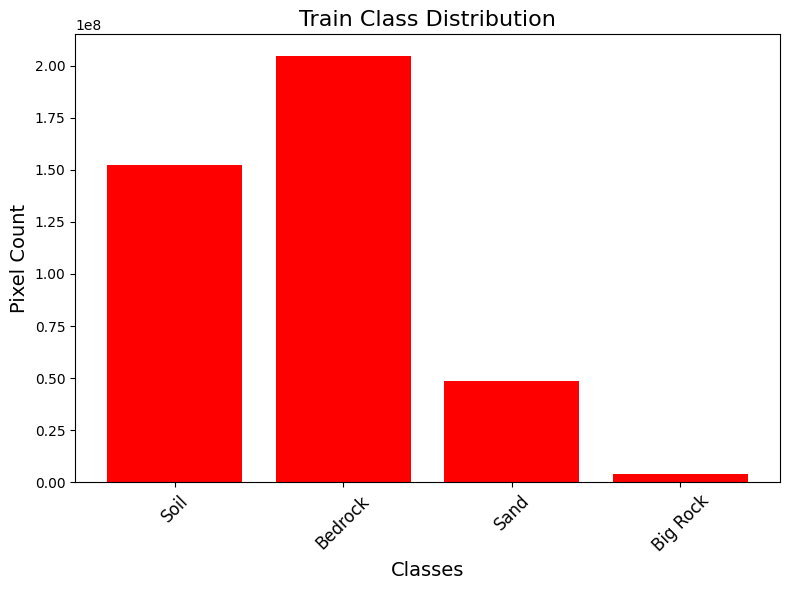

Train Class Percentage Distribution:
  Soil: 37.22%
  Bedrock: 50.00%
  Sand: 11.85%
  Big Rock: 0.92%


Calculating class distribution: 100%|██████████| 2410/2410 [00:16<00:00, 142.86it/s]


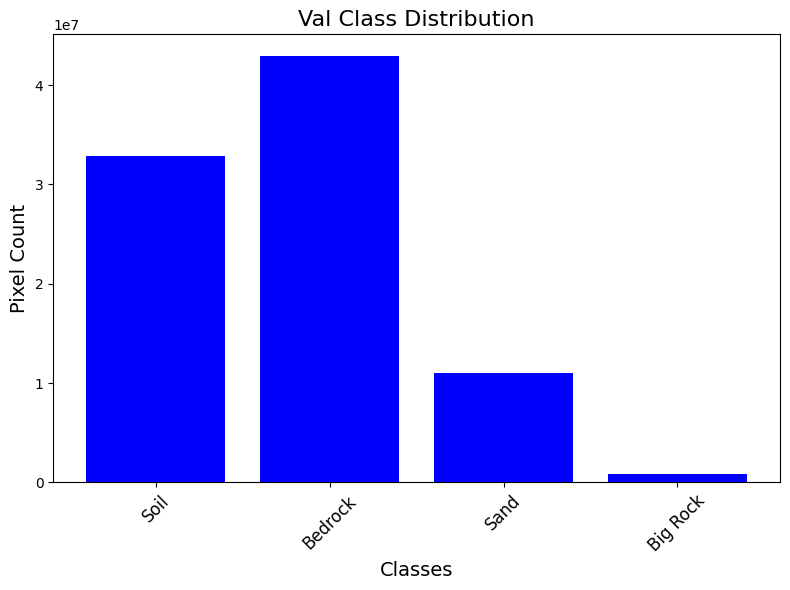

Val Class Percentage Distribution:
  Soil: 37.51%
  Bedrock: 49.00%
  Sand: 12.53%
  Big Rock: 0.96%


Calculating class distribution: 100%|██████████| 2410/2410 [00:16<00:00, 142.93it/s]


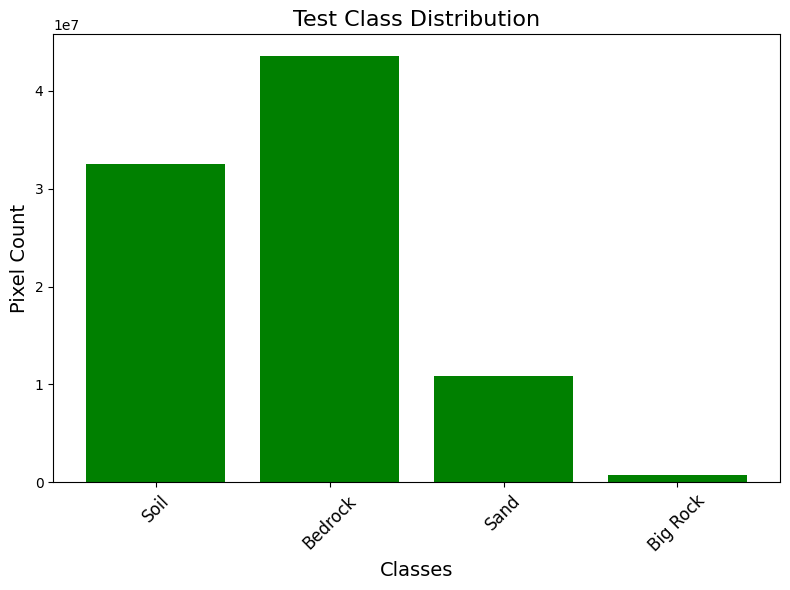

Test Class Percentage Distribution:
  Soil: 37.05%
  Bedrock: 49.69%
  Sand: 12.40%
  Big Rock: 0.87%


In [6]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# Paths
BASE_PATH = "C:/Users/User/Desktop/ai4mars/msl"

# Define classes and their labels
class_labels = ["Soil", "Bedrock", "Sand", "Big Rock"]

# Function to calculate class distribution
def calculate_class_distribution(split_data):
    class_counts = np.zeros(len(class_labels), dtype=np.int64)
    for sample in tqdm(split_data, desc="Calculating class distribution"):
        label_path = sample["mask"]
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale
        for cls in range(len(class_labels)):
            class_counts[cls] += np.sum(label == cls)
    total_pixels = np.sum(class_counts)
    distribution = class_counts / total_pixels if total_pixels > 0 else np.zeros_like(class_counts)
    return class_counts, distribution

# Function to plot class distribution
def plot_class_distribution(class_counts, title, color):
    plt.figure(figsize=(8, 6))
    plt.bar(class_labels, class_counts, color=color)
    plt.xlabel("Classes", fontsize=14)
    plt.ylabel("Pixel Count", fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, fontsize=12)
    plt.tight_layout()
    plt.show()

# Load splits and calculate distributions
split_colors = {"train": "red", "val": "blue", "test": "green"}  # Bar colors for splits
for split_name, color in split_colors.items():
    split_path = os.path.join(BASE_PATH, f"{split_name}_split.json")
    with open(split_path, "r") as f:
        split_data = json.load(f)

    # Calculate class counts and distribution
    class_counts, distribution = calculate_class_distribution(split_data)

    # Plot class distribution
    plot_class_distribution(
        class_counts,
        f"{split_name.capitalize()} Class Distribution",
        color
    )

    # Print percentage distribution
    print(f"{split_name.capitalize()} Class Percentage Distribution:")
    for cls, percentage in enumerate(distribution):
        print(f"  {class_labels[cls]}: {percentage * 100:.2f}%")


In [1]:
import os
import json
import numpy as np
import cv2
from tqdm import tqdm

# Paths
BASE_PATH = "C:/Users/User/Desktop/ai4mars/msl"
SPLIT_PATH = os.path.join(BASE_PATH, "train_split.json")  # Use the training split for weight calculation

# Define classes
class_labels = ["Soil", "Bedrock", "Sand", "Big Rock"]
num_classes = len(class_labels)

# Function to calculate normalized class weights
def calculate_class_weights(split_path):
    class_pixel_counts = np.zeros(num_classes, dtype=np.int64)

    # Load training split
    with open(split_path, "r") as f:
        split_data = json.load(f)

    # Accumulate pixel counts for each class
    for sample in tqdm(split_data, desc="Calculating class weights"):
        label_path = sample["mask"]
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale
        for cls in range(num_classes):
            class_pixel_counts[cls] += np.sum(label == cls)

    # Calculate total pixels
    total_pixels = np.sum(class_pixel_counts)
    if total_pixels == 0:
        raise ValueError("No valid pixels found across all classes. Cannot calculate weights.")

    # Inverse frequency class weights
    raw_weights = total_pixels / (num_classes * class_pixel_counts)

    # Normalize class weights to sum to 1
    normalized_weights = raw_weights / np.sum(raw_weights)
    
    return normalized_weights, class_pixel_counts

# Calculate weights
normalized_weights, class_pixel_counts = calculate_class_weights(SPLIT_PATH)

# Save class weights to JSON
weights_path = os.path.join(BASE_PATH, "class_weights.json")
with open(weights_path, "w") as f:
    json.dump({
        "class_weights": normalized_weights.tolist(),
        "class_pixel_counts": class_pixel_counts.tolist(),
    }, f)
print(f"Class weights saved to {weights_path}")

# Print results
print("Class Pixel Counts:", class_pixel_counts)
print("Normalized Class Weights:", normalized_weights)

Calculating class weights: 100%|██████████| 11244/11244 [00:12<00:00, 878.25it/s]

Class weights saved to C:/Users/User/Desktop/ai4mars/msl\class_weights.json
Class Pixel Counts: [152418072 204734729  48527887   3787105]
Normalized Class Weights: [0.02215728 0.01649534 0.06959235 0.89175502]


Class weights without normalization

In [1]:
import os
import json
import numpy as np
import cv2
from tqdm import tqdm

# Paths
BASE_PATH = "C:/Users/User/Desktop/ai4mars/msl"
SPLIT_PATH = os.path.join(BASE_PATH, "train_split.json")  # Use the training split for weight calculation

# Define classes
class_labels = ["Soil", "Bedrock", "Sand", "Big Rock"]
num_classes = len(class_labels)

# Function to calculate normalized class weights
def calculate_class_weights(split_path):
    class_pixel_counts = np.zeros(num_classes, dtype=np.int64)

    # Load training split
    with open(split_path, "r") as f:
        split_data = json.load(f)

    # Accumulate pixel counts for each class
    for sample in tqdm(split_data, desc="Calculating class weights"):
        label_path = sample["mask"]
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale
        for cls in range(num_classes):
            class_pixel_counts[cls] += np.sum(label == cls)

    # Calculate total pixels
    total_pixels = np.sum(class_pixel_counts)
    if total_pixels == 0:
        raise ValueError("No valid pixels found across all classes. Cannot calculate weights.")

    # Inverse frequency class weights
    class_weights = total_pixels / (num_classes * class_pixel_counts)
    return class_weights, class_pixel_counts

# Calculate weights
class_weights, class_pixel_counts = calculate_class_weights(SPLIT_PATH)

# Save class weights to JSON
weights_path = os.path.join(BASE_PATH, "class_weights.json")
with open(weights_path, "w") as f:
    json.dump({
        "class_weights": class_weights.tolist(),
        "class_pixel_counts": class_pixel_counts.tolist(),
    }, f)
print(f"Class weights saved to {weights_path}")

# Print results
print("Class Pixel Counts:", class_pixel_counts)
print("Normalized Class Weights:", class_weights)

Calculating class weights: 100%|██████████| 11244/11244 [00:13<00:00, 862.24it/s]

Class weights saved to C:/Users/User/Desktop/ai4mars/msl\class_weights.json
Class Pixel Counts: [152418072 204734729  48527887   3787105]
Normalized Class Weights: [ 0.67161949  0.49999797  2.10944582 27.03039611]
